In [1]:
import tensorflow as tf
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

config = tf.ConfigProto(gpu_options=tf.GPUOptions(visible_device_list="1", allow_growth=True))

# load a color image with missing entries
img = imageio.imread('input_IP_house_70_missing.png')

N1 = img.shape[0]
N2 = img.shape[1]
C  = img.shape[2]
N3 = img.shape[2]

tau = 6 # window size of delay embedding (patch size)
r   = 10 # dimension of manifold
sig = 1.0/20.0 # noise level for denoising auto-encoder


In [2]:
# define functions

# making one-hot filters
def make_embfilter(tau):
    fil = np.zeros([tau,tau,1,tau*tau])
    tij = 0
    for ti in range(tau):
        for tj in range(tau):
            fil[ti,tj,0,tij] = 1
            tij = tij+1
    return fil
Hfil = make_embfilter(tau)
Hfil = Hfil.astype('float32')

pad_para_emb   = [[0,0],[tau-1,tau-1],[tau-1,tau-1],[0,0]]
pad_type_emb   = 'symmetric'

# delay-embedding layer
def H(z):
    z = tf.pad(z,pad_para_emb,pad_type_emb)
    return tf.nn.conv2d(z,Hfil,strides=[1,1,1,1],padding='VALID')

# inverse delay-embedding layer
def Hinv(z):
    z_size = np.array(z.shape,dtype='int32')
    Htz = tf.nn.conv2d_transpose(z,Hfil,output_shape=[z_size[0],
                                                      z_size[1]+tau-1,
                                                      z_size[2]+tau-1,
                                                      Hfil.shape[2]],strides=[1,1,1,1],padding='VALID')
    return Htz[:,tau-1:z_size[1],tau-1:z_size[2],:]/tau/tau


## autoencoder
def NN(data,ranks):
    Z0 = tf.layers.dense(data,ranks[0])
    Z0 = tf.nn.leaky_relu(Z0)
    Z1 = tf.layers.dense(Z0,ranks[1])
    Z1 = tf.nn.leaky_relu(Z1)
    Z2 = tf.layers.dense(Z1,ranks[2])
    Z2 = tf.nn.leaky_relu(Z2)
    Z3 = tf.layers.dense(Z2,ranks[3])
    Z3 = tf.nn.leaky_relu(Z3)
    Z4 = tf.layers.dense(Z3,ranks[4])
    Z4 = tf.nn.leaky_relu(Z4)
    Z5 = tf.layers.dense(Z4,data.shape[1])
    return Z5

In [3]:
## problem def

#dimensions of intermediate layers in denoising auto-encoder 
ranks = [tau*tau, tau*tau, r, tau*tau, tau*tau]

X = tf.Variable(tf.random_uniform([C,N2,N1,1], dtype=tf.float32))
Hx=tf.transpose(tf.reshape(tf.transpose(H(X)),[tau*tau,C*(N2+tau-1)*(N1+tau-1)]))
noise= tf.random_normal(Hx.shape,0.0,sig,dtype=tf.float32)
AHx  = NN(Hx+noise,ranks)
Xrec = Hinv(tf.transpose(tf.reshape(tf.transpose(AHx),[tau*tau,N1+tau-1,N2+tau-1,C])))

Y  = tf.sigmoid(tf.transpose(tf.layers.conv2d(tf.transpose(Xrec),filters=N3,kernel_size=[1,1],padding="same",strides=(1,1))))

label_node = tf.placeholder(tf.float32,shape=(N3,N2,N1,1))
mask_node  = tf.placeholder(tf.float32,shape=(N3,N2,N1,1))
lam_ph = tf.placeholder(tf.float32,())

rec_loss  = tf.losses.mean_squared_error(label_node, tf.multiply(Y,mask_node))
ae_loss1  = tf.losses.mean_squared_error(Hx, AHx)

ae_loss   = lam_ph/tau/tau*( ae_loss1 )
cost = rec_loss + ae_loss


BATCH_SIZE = 1

batch = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    0.01,                 # Base learning rate.
    batch*BATCH_SIZE,     # Current index into the dataset.
    100,                  # Decay step.
    0.98,                 # Decay rate.
    staircase=True)

update = tf.train.AdamOptimizer(learning_rate).minimize(cost, global_step=batch)

init = tf.global_variables_initializer()



Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


<IPython.core.display.Javascript object>


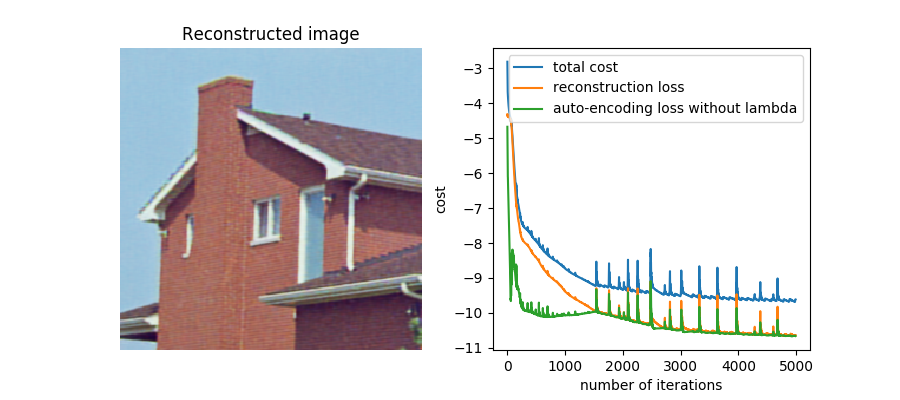

In [4]:
%matplotlib notebook
fig = plt.figure(figsize=(9,4),dpi=100)
ax2 = fig.add_subplot(1,2,1)
ax3 = fig.add_subplot(1,2,2)


In [5]:
import time
import random
import scipy.io

num_iter = 5000
cost_hist = np.zeros([num_iter,3])
start_time = time.time()
time_hist = np.zeros([num_iter,1])

sc = 255.0

# making mask tensor from an input image
msk = np.where(img==0,0.0,1.0)

# reshape
label_data = np.transpose(np.reshape(img.astype(np.float32),[1,N1,N2,N3])/sc)
mask_data  = np.transpose(np.reshape(msk.astype(np.float32),[1,N1,N2,N3]))

lam = 5.0 # initial value of lambda (this is adjustable)
with tf.Session(config=config) as sess:
    sess.run(init)
    print('Iinitialized!')
    for step in range(0,num_iter):
        _, cost_value,cost_rec,cost_ae, y_est, x_est = sess.run([update,cost,rec_loss,ae_loss,Y,X],{label_node:label_data,mask_node:mask_data,lam_ph:lam})
        l_rate = sess.run(learning_rate)
        cost_hist[step,0] = cost_value
        cost_hist[step,1] = cost_rec
        cost_hist[step,2] = cost_ae/lam
        time_hist[step] = time.time() - start_time
        if step %10 == 0:
            elapsed_time = time.time() - start_time
            if cost_rec < cost_ae/lam:
                lam = lam*1.1
            elif cost_ae/lam < cost_rec:
                lam = lam*0.99
            print('Step %d / %d :: %f :: %f :: %f ' % (step,num_iter,cost_value,l_rate,lam))
            ax2.clear()
            ax2.imshow(np.transpose(np.reshape(255.0*y_est,[3,N2,N1])).astype(np.uint8))
            ax2.set_title("Reconstructed image")
            ax2.axis("off")
            ax3.clear()
            ax3.plot(np.log(cost_hist[0:step,0]), label="total cost")
            ax3.plot(np.log(cost_hist[0:step,1]), label="reconstruction loss")
            ax3.plot(np.log(cost_hist[0:step,2]), label="auto-encoding loss without lambda")
            ax3.legend()
            ax3.set_xlabel("number of iterations")
            ax3.set_ylabel("cost")
            fig.canvas.draw()
            numstr = '%05d' % step
imageio.imsave('output_IP.png',np.transpose(np.reshape(255.0*y_est,[3,N2,N1])).astype(np.uint8))

Iinitialized!
Step 0 / 5000 :: 0.059931 :: 0.010000 :: 4.950000 
Step 10 / 5000 :: 0.022190 :: 0.010000 :: 4.900500 
Step 20 / 5000 :: 0.017404 :: 0.010000 :: 4.851495 
Step 30 / 5000 :: 0.014705 :: 0.010000 :: 4.802980 
Step 40 / 5000 :: 0.013230 :: 0.010000 :: 4.754950 
Step 50 / 5000 :: 0.012339 :: 0.010000 :: 4.707401 
Step 60 / 5000 :: 0.011404 :: 0.010000 :: 4.660327 
Step 70 / 5000 :: 0.010177 :: 0.010000 :: 4.613723 
Step 80 / 5000 :: 0.008594 :: 0.010000 :: 4.567586 
Step 90 / 5000 :: 0.006812 :: 0.010000 :: 4.521910 
Step 100 / 5000 :: 0.005195 :: 0.009800 :: 4.476691 
Step 110 / 5000 :: 0.003968 :: 0.009800 :: 4.431924 
Step 120 / 5000 :: 0.003049 :: 0.009800 :: 4.387605 
Step 130 / 5000 :: 0.002388 :: 0.009800 :: 4.343729 
Step 140 / 5000 :: 0.001909 :: 0.009800 :: 4.300292 
Step 150 / 5000 :: 0.001656 :: 0.009800 :: 4.257289 
Step 160 / 5000 :: 0.001465 :: 0.009800 :: 4.214716 
Step 170 / 5000 :: 0.001227 :: 0.009800 :: 4.172569 
Step 180 / 5000 :: 0.001106 :: 0.009800 :: 

Step 1540 / 5000 :: 0.000197 :: 0.007386 :: 1.169991 
Step 1550 / 5000 :: 0.000113 :: 0.007386 :: 1.158291 
Step 1560 / 5000 :: 0.000107 :: 0.007386 :: 1.146709 
Step 1570 / 5000 :: 0.000103 :: 0.007386 :: 1.135241 
Step 1580 / 5000 :: 0.000100 :: 0.007386 :: 1.123889 
Step 1590 / 5000 :: 0.000098 :: 0.007386 :: 1.112650 
Step 1600 / 5000 :: 0.000097 :: 0.007238 :: 1.223915 
Step 1610 / 5000 :: 0.000102 :: 0.007238 :: 1.211676 
Step 1620 / 5000 :: 0.000100 :: 0.007238 :: 1.199559 
Step 1630 / 5000 :: 0.000100 :: 0.007238 :: 1.187564 
Step 1640 / 5000 :: 0.000099 :: 0.007238 :: 1.175688 
Step 1650 / 5000 :: 0.000098 :: 0.007238 :: 1.163931 
Step 1660 / 5000 :: 0.000097 :: 0.007238 :: 1.152292 
Step 1670 / 5000 :: 0.000096 :: 0.007238 :: 1.140769 
Step 1680 / 5000 :: 0.000095 :: 0.007238 :: 1.254846 
Step 1690 / 5000 :: 0.000099 :: 0.007238 :: 1.242297 
Step 1700 / 5000 :: 0.000099 :: 0.007093 :: 1.229874 
Step 1710 / 5000 :: 0.000098 :: 0.007093 :: 1.217576 
Step 1720 / 5000 :: 0.000097

Step 3060 / 5000 :: 0.000080 :: 0.005455 :: 1.879856 
Step 3070 / 5000 :: 0.000079 :: 0.005455 :: 1.861057 
Step 3080 / 5000 :: 0.000078 :: 0.005455 :: 1.842447 
Step 3090 / 5000 :: 0.000077 :: 0.005455 :: 1.824022 
Step 3100 / 5000 :: 0.000077 :: 0.005346 :: 1.805782 
Step 3110 / 5000 :: 0.000076 :: 0.005346 :: 1.787724 
Step 3120 / 5000 :: 0.000076 :: 0.005346 :: 1.769847 
Step 3130 / 5000 :: 0.000075 :: 0.005346 :: 1.752149 
Step 3140 / 5000 :: 0.000074 :: 0.005346 :: 1.734627 
Step 3150 / 5000 :: 0.000074 :: 0.005346 :: 1.717281 
Step 3160 / 5000 :: 0.000074 :: 0.005346 :: 1.700108 
Step 3170 / 5000 :: 0.000073 :: 0.005346 :: 1.683107 
Step 3180 / 5000 :: 0.000072 :: 0.005346 :: 1.666276 
Step 3190 / 5000 :: 0.000072 :: 0.005346 :: 1.649613 
Step 3200 / 5000 :: 0.000071 :: 0.005239 :: 1.814574 
Step 3210 / 5000 :: 0.000076 :: 0.005239 :: 1.796429 
Step 3220 / 5000 :: 0.000077 :: 0.005239 :: 1.778464 
Step 3230 / 5000 :: 0.000074 :: 0.005239 :: 1.760680 
Step 3240 / 5000 :: 0.000074

Step 4580 / 5000 :: 0.000068 :: 0.004029 :: 1.783524 
Step 4590 / 5000 :: 0.000067 :: 0.004029 :: 1.765689 
Step 4600 / 5000 :: 0.000073 :: 0.003948 :: 1.748032 
Step 4610 / 5000 :: 0.000067 :: 0.003948 :: 1.730552 
Step 4620 / 5000 :: 0.000066 :: 0.003948 :: 1.713246 
Step 4630 / 5000 :: 0.000066 :: 0.003948 :: 1.696114 
Step 4640 / 5000 :: 0.000065 :: 0.003948 :: 1.679153 
Step 4650 / 5000 :: 0.000064 :: 0.003948 :: 1.662361 
Step 4660 / 5000 :: 0.000064 :: 0.003948 :: 1.828597 
Step 4670 / 5000 :: 0.000073 :: 0.003948 :: 1.810311 
Step 4680 / 5000 :: 0.000073 :: 0.003948 :: 1.792208 
Step 4690 / 5000 :: 0.000071 :: 0.003948 :: 1.774286 
Step 4700 / 5000 :: 0.000069 :: 0.003869 :: 1.756543 
Step 4710 / 5000 :: 0.000067 :: 0.003869 :: 1.738978 
Step 4720 / 5000 :: 0.000066 :: 0.003869 :: 1.721588 
Step 4730 / 5000 :: 0.000065 :: 0.003869 :: 1.704372 
Step 4740 / 5000 :: 0.000065 :: 0.003869 :: 1.687328 
Step 4750 / 5000 :: 0.000064 :: 0.003869 :: 1.670455 
Step 4760 / 5000 :: 0.000064